<a href="https://colab.research.google.com/github/GauravPatel1102/Denoising-Image-using-GAN/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import & get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.15.0 ml-dtypes tf-keras


INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes

In [ ]:
import tensorflow as tf
import os

print(tf.__version__)

2.15.0


In [ ]:
data_train = '/content/drive/MyDrive/Training dataset/*'
data_test = '/content/drive/MyDrive/input/*'
checkpoint_dir = '/content/drive/MyDrive/Work_Share/Pix2Pix_Denoising_and_Super_Resolution/checkpoint/'
buffer_size = 20
batch_size = 1
img_height = 256
img_width = 1024
low_height = 64
low_width = 256
epochs = 150

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class SubPixel(layers.Layer):
    def __init__(self, upscale_factor, channels, activation=None):
        super(SubPixel, self).__init__()
        self.upscale_factor = upscale_factor
        self.channels = channels
        self.activation = activation

    def __call__(self, inputs):
        x = layers.Conv2D(self.channels*(self.upscale_factor ** 2), 3, padding="same",
                            activation=self.activation, kernel_initializer="Orthogonal")(inputs)
        outputs = tf.nn.depth_to_space(x, self.upscale_factor)
        return outputs

def extract_first_features(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                        strides=1, padding='same', use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())

    return result

def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=2, padding='same', use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    # Conv2DTranspose stride=2
    result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=2, padding='same', use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def downsample_sr(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=1, padding='same', use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())

    return result

def upsample_sr(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    # Conv2DTranspose stride=2
    result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=2, padding='same', use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.LeakyReLU())

    return result

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models



def DiscriminatorDenoise():
    # https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator

    inp = tf.keras.layers.Input(shape=[low_height, low_width, 3])
    tar = tf.keras.layers.Input(shape=[low_height, low_width, 3])
    x = tf.keras.layers.concatenate([inp, tar])

    x = downsample(filters=64,  size=4, apply_batchnorm=False)(x)
    x = downsample(filters=128, size=4, apply_batchnorm=True)(x)
    x = downsample(filters=256, size=4, apply_batchnorm=True)(x)

    initializer1 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    initializer2 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    x = layers.Conv2D(filters=256, kernel_size=3, kernel_initializer=initializer1,
                            strides=1, use_bias=False)(x)
    x = layers.Conv2D(filters=1, kernel_size=3, kernel_initializer=initializer2,
                            strides=1, use_bias=False)(x)

    model = models.Model(inputs=[inp,tar], outputs=x)

    return model

def DiscriminatorSR():
    # https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator

    inp = tf.keras.layers.Input(shape=[img_height, img_width, 3])

    x = downsample(filters=64,  size=4, apply_batchnorm=False)(inp)
    x = downsample(filters=128, size=4, apply_batchnorm=True)(x)
    x = downsample(filters=256, size=4, apply_batchnorm=True)(x)

    initializer1 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    initializer2 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    x = layers.Conv2D(filters=256, kernel_size=3, kernel_initializer=initializer1,
                            strides=1, use_bias=False)(x)
    x = layers.Conv2D(filters=1, kernel_size=3, kernel_initializer=initializer2,
                            strides=1, use_bias=False)(x)

    model = models.Model(inputs=inp, outputs=x)

    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


def UNet_process(x):
    """
    feature image input -> noise free image

    """
    down_stack = [
        downsample(filters=64, size=4, apply_batchnorm=False),
        downsample(filters=256, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
    ]

    up_stack = [
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=256, size=4, apply_dropout=True),
        upsample(filters=64, size=4, apply_dropout=False),
    ]

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    last = layers.Conv2DTranspose(filters=3, kernel_size=4, kernel_initializer=initializer,
                            strides=2, padding='same', activation='tanh')

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return x

def Generator():
    """
    model denoise and super resolution ((x4 size))

    """
    inputs = layers.Input(shape=(low_height, low_width, 3))
    x = extract_first_features(filters=64, size=3, apply_batchnorm=True)(inputs)
    x = UNet_process(x)
    fake_lr = x

    x = extract_first_features(filters=64, size=3, apply_batchnorm=True)(x)
    x = downsample_sr(filters=256, size=3, apply_batchnorm=True)(x)
    x = downsample_sr(filters=256, size=3, apply_batchnorm=True)(x)

    x = upsample_sr(filters=128, size=4, apply_dropout=False)(x)

    x = downsample_sr(filters=128, size=3, apply_batchnorm=True)(x)

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    last = layers.Conv2DTranspose(filters=3, kernel_size=4, kernel_initializer=initializer,
                            strides=2, padding='same', activation='tanh')

    fake_hr = last(x)

    model = models.Model(inputs=inputs, outputs=[fake_lr, fake_hr])

    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


def discriminator_loss(disc_real_output, disc_generated_output):

    loss_dsic_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.03)

    real_los = loss_dsic_object(tf.ones_like(disc_real_output), disc_real_output)

    fake_los = loss_dsic_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_loss = real_los + fake_los

    return total_loss

def generator_denoise_loss(disc_generated_output, gen_output, target):

    bce  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    LAMBDA = 40

    gan_loss = bce(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_loss = gan_loss + LAMBDA*l1_loss

    return total_loss, gan_loss, l1_loss

def generator_sr_loss(disc_generated_output, gen_output, target):

    bce  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    LAMBDA = 40

    gan_loss = bce(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_loss = gan_loss + LAMBDA*l1_loss

    return total_loss, gan_loss, l1_loss

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt


def load(image_path):
    """
    Parameters
    ----------
    image_path : string

    Returns
    -------
    image_lr: tf.Tensor (tf.float32) input low resolution and noise
    target_lr: tf.Tensor (tf.float32) target low resolution and not noise
    target_hr: tf.Tensor (tf.float32) target high resolution
    """

    # read file and decode image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image)

    # resize image_lr, target_lr with low_width and low_height
    image_lr = tf.image.resize(image, size=(low_height, low_width))
    target_lr = tf.image.resize(image, size=(low_height, low_width))

    # resize target_hr IMG_WIDTH and IMG_HEIGHT
    target_hr = tf.image.resize(image, size=(img_height, img_width))

    # create noise matrix has size with low_width and low_height
    noise_per = 0.20
    noise = tf.random.uniform(shape=(low_height, low_width, 3), minval=1-noise_per, maxval=1+noise_per)

    # Convert image to float32 tensors
    image_lr = tf.cast(image_lr, dtype=tf.float32)
    target_lr = tf.cast(target_lr, dtype=tf.float32)
    target_hr = tf.cast(target_hr, dtype=tf.float32)

    # image_lr multiply noise matrix -> noise image
    image_lr = image_lr*noise
    image_lr = tf.clip_by_value(image_lr, 0, 255)

    return image_lr, target_lr, target_hr

def normalize(image_lr, target_lr, target_hr):
    """
    normalizing the images to [-1, 1]

    """
    image_lr  = (image_lr/127.5) - 1
    target_lr = (target_lr/127.5) - 1
    target_hr = (target_hr/127.5) - 1

    return image_lr, target_lr, target_hr

#@tf.function()
def random_jitter(image_lr, target_lr, target_hr):
    """
    There is a 50% chance of flipping the image from left to right

    """
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        image_lr  = tf.image.flip_left_right(image_lr)
        target_lr  = tf.image.flip_left_right(target_lr)
        target_hr  = tf.image.flip_left_right(target_hr)

    return image_lr, target_lr, target_hr

def load_image_train(image_path):
    """
    load image, random_jitter and normalize image

    """
    image_lr, target_lr, target_hr = load(image_path)

    image_lr, target_lr, target_hr = random_jitter(image_lr, target_lr, target_hr)

    image_lr, target_lr, target_hr = normalize(image_lr, target_lr, target_hr)

    return image_lr, target_lr, target_hr

def load_image_test(image_path):
    """
    load image and normalize image

    """

    image_lr, target_lr, target_hr = load(image_path)

    image_lr, target_lr, target_hr = normalize(image_lr, target_lr, target_hr)

    return image_lr, target_lr, target_hr


def evaluate(model, epoch, data):
    psnr_mean = 0.0
    for image_lr, target_lr, target_hr in data:
        fake_lr, fake_hr = model(image_lr, training=False)
        psnr_b = tf.image.psnr(fake_hr, target_hr, max_val=1.0)
        psnr_mean = tf.math.reduce_mean(psnr_b)

#     psnr_mean = psnr_mean/10.0
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch)
    return psnr_mean


def generate_images(model, image_lr, target_sr, is_fake_lr=False):
    fake_lr, fake_hr = model([image_lr], training=False)
    if is_fake_lr:
        display_list = [image_lr[0], fake_lr[0], target_sr[0], fake_hr[0]]
        title_l = ['Input', 'Denoise', 'Real', 'Generated']
        plt.figure(figsize=(25,30))
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.title(title_l[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
    else:
        display_list = [image_lr[0], target_sr[0], fake_hr[0]]
        title_l = ['Input', 'Real', 'Generated']
        plt.figure(figsize=(25,30))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title_l[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.show()

### dataset & model

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(data_train)

train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.batch(1)

# test_dataset
test_dataset = tf.data.Dataset.list_files(data_test)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

generator = Generator()
discriminator1 = DiscriminatorDenoise()
discriminator2 = DiscriminatorSR()

generator_optimizer     = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator1_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)
discriminator2_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)


checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator1_optimizer=discriminator1_optimizer,
                                discriminator2_optimizer=discriminator2_optimizer,
                                generator=generator,
                                discriminator1=discriminator1,
                                discriminator2=discriminator2)

### training

In [ ]:
@tf.function
def train_step(image_lr, target_lr, target_hr):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc1_tape, tf.GradientTape() as disc2_tape:

        fake_lr, fake_hr = generator(image_lr, training=True)

        disc_lr_real_output = discriminator1([image_lr,target_lr], training=True)
        disc_lr_generated_output = discriminator1([image_lr, fake_lr], training=True)

        disc_hr_real_output = discriminator2(target_hr, training=True)
        disc_hr_generated_output = discriminator2(fake_hr, training=True)

        total_lr_loss, gan_lr_loss, l1_lr_loss = generator_denoise_loss(disc_lr_generated_output, fake_lr, target_lr)
        total_hr_loss, gan_hr_loss, l1_hr_loss = generator_sr_loss(disc_hr_generated_output, fake_hr, target_hr)

        disc_lr_loss = discriminator_loss(disc_lr_real_output, disc_lr_generated_output)
        disc_hr_loss = discriminator_loss(disc_hr_real_output, disc_hr_generated_output)

        gan_loss = gan_lr_loss + gan_hr_loss
        l1_loss = l1_lr_loss + l1_hr_loss
        disc_loss = disc_lr_loss + disc_hr_loss

        total_gen_loss = total_lr_loss + total_hr_loss

    gen_gradients = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    disc1_gradients = disc1_tape.gradient(disc_lr_loss, discriminator1.trainable_variables)
    disc2_gradients = disc2_tape.gradient(disc_hr_loss, discriminator2.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator1_optimizer.apply_gradients(zip(disc1_gradients, discriminator1.trainable_variables))
    discriminator2_optimizer.apply_gradients(zip(disc2_gradients, discriminator2.trainable_variables))

    return gan_loss, l1_loss, disc_loss

def fit(train_ds, epochs, test_ds):
    best_psnr = 0.0
    for epoch in range(epochs):

        for image_lr, target_lr, target_hr in train_ds:
            gan_loss, l1_loss, disc_loss = train_step(image_lr, target_lr, target_hr)

        psnr = evaluate(generator, epoch, test_ds)
        if best_psnr < psnr:
            checkpoint.save(file_prefix = checkpoint_prefix)
            best_psnr = psnr

            for image_lr, target_lr, target_hr in test_ds.take(1):
                generate_images(generator, image_lr, target_hr)

        print('epoch {}  gan_loss: {}  l1_loss: {}  disc_loss: {}'.format(epoch, gan_loss, l1_loss, disc_loss))

In [ ]:
epochs = 120
fit(train_dataset, epochs, test_dataset)

KeyboardInterrupt: 

### save weight

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

KeyboardInterrupt: 

In [ ]:
generator.save_weights('/content/drive/MyDrive/Work_Share/Pix2Pix_Denoising_and_Super_Resolution/weights/')

### predict

In [ ]:
generator.load_weights('/content/drive/MyDrive/Work_Share/Pix2Pix_Denoising_and_Super_Resolution/weights/')

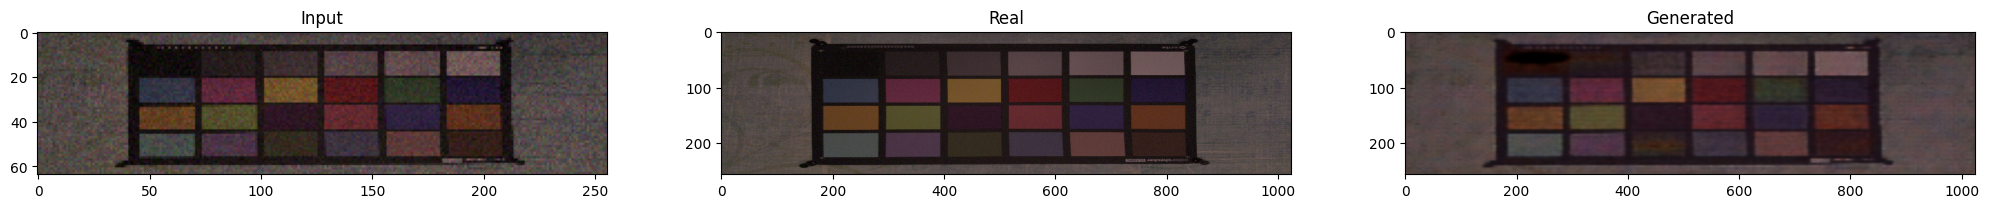

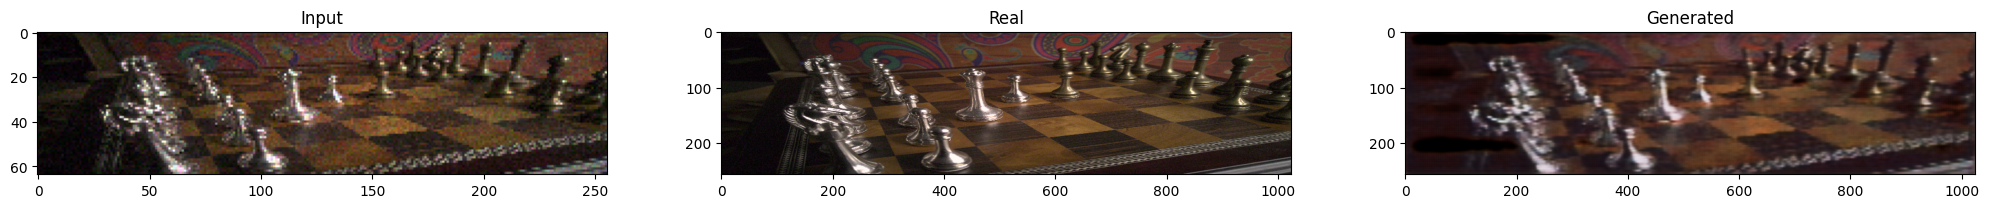

In [ ]:
for image_lr, target_lr, target_hr in test_dataset.take(5):
    generate_images(generator, image_lr, target_hr, is_fake_lr=False)